 > **WARNING:** If, for some reason, you are unable to see the output of each code block, please open this Google Colab link: https://colab.research.google.com/drive/1_EOYkQq73TCnpnQ-MOMAV9NpvSVhmzAI?usp=sharing


> **Note:** The files *Columns.csv* and *RawData.csv* were loaded to this notebook using the python function *open(\<path file\>)*, instead of the usual Azure Data Lake method (https://learn.microsoft.com/pt-br/azure/databricks/archive/credential-passthrough/adls-passthrough#python-3), because I don't have a personal AZURE subscription to test this inside the Microsoft Azure Portal, so instead I used a normal python notebook.


# Databricks Notebook
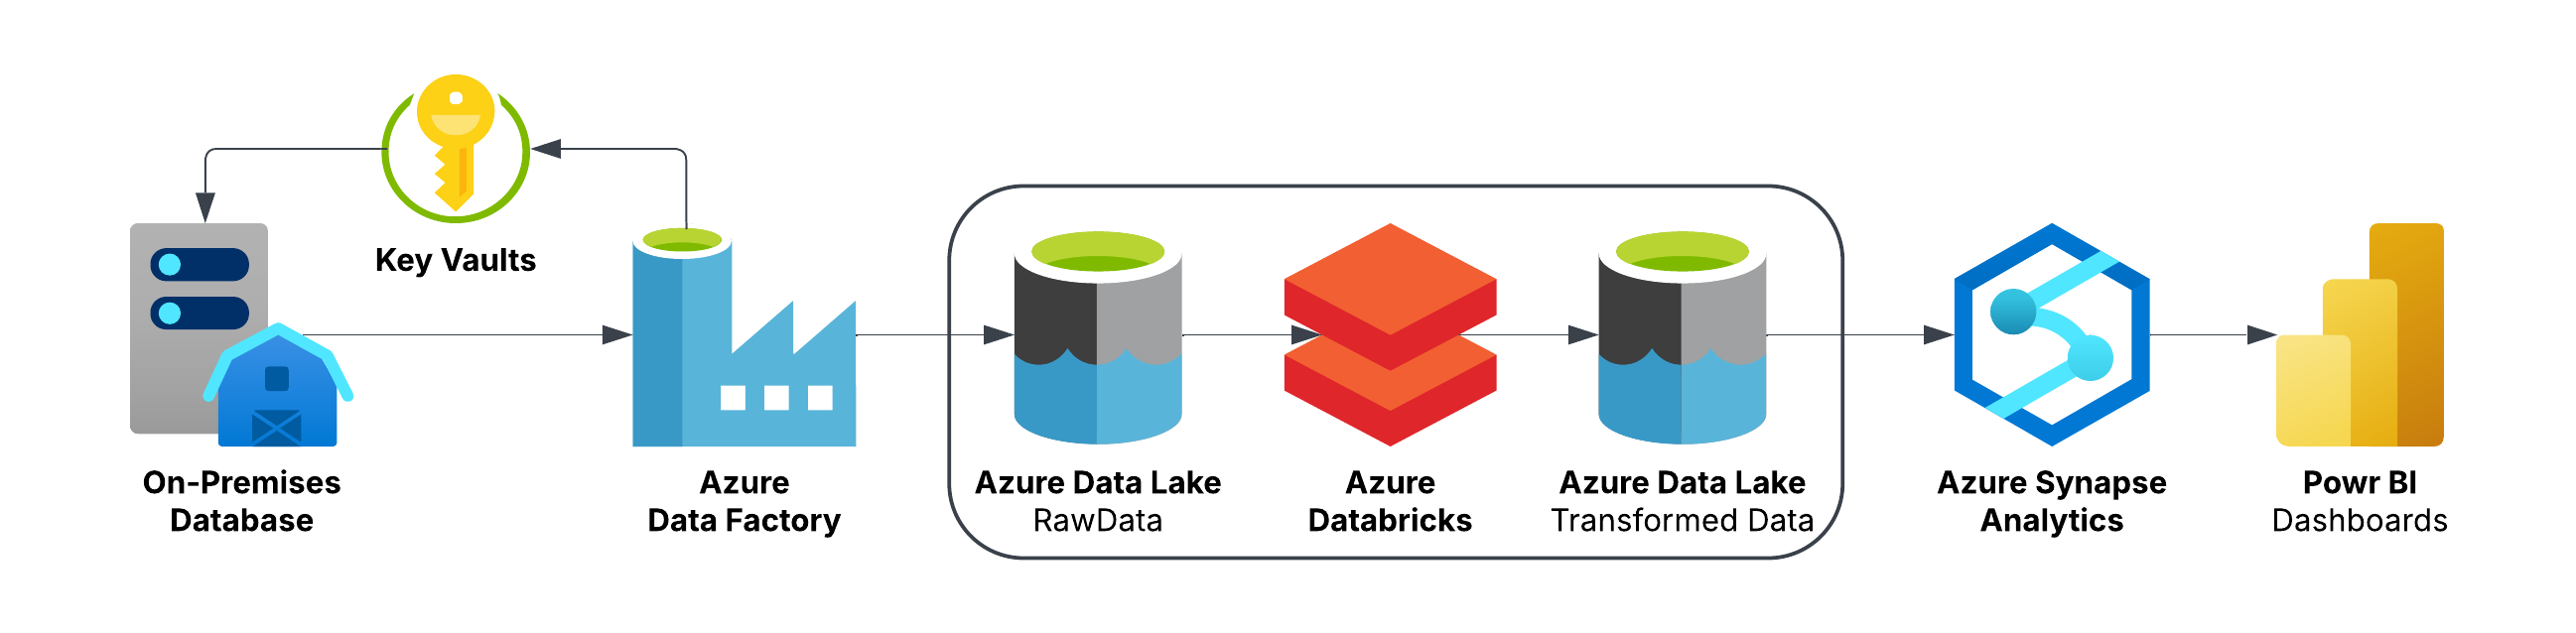

In this python notebook I have the "extracted data" from the On-Premise SQL Database and got 2 csv files, the 'Columns.csv' and the 'RawData.csv'.

In [1]:
file_path_columns = "Columns.csv"
file_path_rawdata = "RawData.csv"

with open(file_path_columns, 'rb') as f:
    columns = f.read()

with open(file_path_rawdata, 'rb') as f:
    rawdata = f.read()

Now that I have extracted the information, it is time to transform it, taking into consideration a few business rules mentioned in the script. The rules are as follows:
 1. There might be some issues with encoding, business people are unaware if they used UTF-8/ANS. We need this fixed in order to see all characters!
 2. Respondents should be unique;
 3. If 'Student' is blank, it means **NO**;
 4. If 'Employment' is blank, consider a **full time job**;
 5. If multiple fields are not filled (more than 3), you can disregard, since it does not count as a valid response.
 6. They would like to see all salaries Yearly.


 Let's start with the first point.

## 1. There might be some issues with encoding, business people are unaware if they used UTF-8/ANS. We need this fixed in order to see all characters!

To ensure this, I will open and read the files 'Columns.csv' and 'RawData.csv' and use the method 'detect' from the module chardet, which returns a dictionary where one of the key-value pairs indicates the encoding type of the documents.

In [2]:
import chardet

detect_columns = chardet.detect(columns)
detect_rawdata = chardet.detect(rawdata)

print(f"[RawData.csv] Detected encoding : {detect_columns['encoding']}")
print(f"[RawData.csv] Detected encoding : {detect_rawdata['encoding']}")

[RawData.csv] Detected encoding : utf-8
[RawData.csv] Detected encoding : utf-8


Great! Our encoding is UTF-8, so we are good to go!

Let's create our DataFrame using **pyspark.sql**

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, sum, expr

# Initialize Spark Session
spark = SparkSession.builder.appName("ETL_Vasco").getOrCreate()

Let's load 'RawData.csv' into a dataframe using the fucntion 'spark.read.csv', taking into consideration the following argumens:
 - **header = True**, this tells Spark that the first row of your CSV file contains the column names.
 - **inferSchema = True**, this instructs Spark to automatically determine the data types of each column based on the content of the CSV file.
 - **multiline = True**, this parameter allows Spark to handle CSV records that span multiple lines.
 - **escape = ' " '**, this specifies the escape character used in the CSV file. For example, the string "He said, ""Hello!"" " would be interpreted as He said, "Hello!".


 Enconding is set to UTF-8 by default.

In [4]:
# Load CSV files with proper encoding
data_df = spark.read.csv("RawData.csv", header=True, inferSchema=True, multiLine=True, escape='"')

# Show processed data truncated
data_df.show()

+----------+-----+----------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+------+----------+---------------+--------------+--------------------+-------------------+--------------------+------

In [5]:
row_count = data_df.count()
print(f"Number of rows: {row_count}")

Number of rows: 10000


## 2. Respondents Should Be Unique
Let's check if we have any repeated 'Respondent' values. For that, I used the *groupby* and *count* methods.

* *groupby*, groups the rows in the data_df DataFrame by the values in the 'Respondent' column.
* *count*, counts the number of rows for each unique value in the 'Respondent' column.

The result is a new DataFrame called 'respondent_counts', which has two columns: 'Respondent' and 'count'. The 'count' column shows how many times each respondent appears in the original DataFrame.

In [6]:
# Group by 'Respondent' and count occurrences
respondent_counts = data_df.groupBy("Respondent").count()
respondent_counts.show()

+----------+-----+
|Respondent|count|
+----------+-----+
|     56987|    1|
|      6397|    1|
|     26755|    1|
|     80579|    1|
|     49308|    1|
|      4101|    1|
|     18911|    1|
|     22521|    1|
|     18800|    1|
|     64822|    1|
|     29194|    1|
|     13832|    1|
|     24347|    1|
|     75122|    1|
|     79220|    1|
|     37251|    1|
|     90550|    1|
|     65220|    1|
|     34239|    1|
|     69637|    1|
+----------+-----+
only showing top 20 rows



Full output:

In [7]:
respondent_counts.show(n=data_df.count(), truncate=False)

+----------+-----+
|Respondent|count|
+----------+-----+
|56987     |1    |
|6397      |1    |
|26755     |1    |
|80579     |1    |
|49308     |1    |
|4101      |1    |
|18911     |1    |
|22521     |1    |
|18800     |1    |
|64822     |1    |
|29194     |1    |
|13832     |1    |
|24347     |1    |
|75122     |1    |
|79220     |1    |
|37251     |1    |
|90550     |1    |
|65220     |1    |
|34239     |1    |
|69637     |1    |
|17679     |1    |
|68202     |1    |
|78478     |1    |
|17389     |1    |
|64590     |1    |
|19553     |1    |
|49855     |1    |
|26708     |1    |
|44358     |1    |
|91784     |1    |
|29814     |1    |
|1580      |1    |
|42635     |1    |
|62985     |1    |
|25591     |1    |
|7340      |1    |
|70097     |1    |
|50353     |1    |
|70355     |1    |
|97004     |1    |
|24354     |1    |
|67782     |1    |
|34061     |1    |
|61793     |1    |
|51595     |1    |
|18944     |1    |
|2366      |1    |
|37489     |1    |
|59990     |1    |
|76493     |

Now, we can check if there is any 'Respondent' with more than one entry by filtering the previous table.

In [8]:
# Filter for respondents appearing more than once
duplicate_respondents = respondent_counts.filter(col("count") > 1)

# Show duplicate respondents
duplicate_respondents.show()

+----------+-----+
|Respondent|count|
+----------+-----+
+----------+-----+



'duplicate_respondents' is empty, that said the uniqueness of 'respondent' is secured. Moving to the next rule.

## 3. If 'Student' is blank, it means **NO**;

Let's check which rows have the 'Student' field blank by using *PySpark* and filtering the DataFrame, data_df.

In [9]:
# Filter the DataFrame to get the rows with null or empty "Student" values
filtered_df = data_df.filter(col("Student").isNull())
filtered_df.show()

+----------+-----+----------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+------------------+------+----------+---------------+--------------+--------------------+-------------------+--------------------+--------------

Full output:

In [10]:
filtered_df.show(n=data_df.count(), truncate=False)

+----------+-----+----------+------------------------------------+-------+----------------------------------------------------+----------------------------------------------------------------------------------+---------------------------------------------------------------------+------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+---------------+----------------------------------+----------------------------------+---------------------------------------------------------------------------------+--------------------------------------------------------

In [11]:
# Count the number of rows and print it
empty_student_count = filtered_df.count()
print(f"Number of rows with null or empty 'Student' values: {empty_student_count}")

Number of rows with null or empty 'Student' values: 232


As we can see, we have 232 cases that require action. We will fix this using the *withColumn* method, which replaces the 'Student' column with a modified version of itself, following this logic:

  *when(col("Student").isNull(), "No").otherwise(col("Student")*

This checks if the 'Student' column is NULL, if the condition is true, the function returns "No". Otherwise, it retains its original value *col("Student")*.

In [12]:
data_df = data_df.withColumn(
    "Student",
    when(col("Student").isNull(), "No").otherwise(col("Student"))
)

In [13]:
# Filter the DataFrame to get the rows with null "Student" values
filtered_df = data_df.filter(col("Student").isNull())

# Count the number of rows in the filtered DataFrame and print it
empty_student_count = filtered_df.count()
print(f"Number of rows with NULL 'Student' values: {empty_student_count}")

Number of rows with NULL 'Student' values: 0


Problem fixed! We now have 0 rows with the 'Student' field as NULL.

Now, let's apply the same process to the 'Employment' column.

## 4. If 'Employment' is blank, consider a full time job

Filter the DataFrame to get the rows with empty "Employment" values.

In [14]:
filtered_df = data_df.filter(col("Employment").isNull())
filtered_df.show()

+----------+-----+----------+--------------+--------------+----------+--------------------+--------------------+-----------+--------------------+-----------+----------------+---------------+--------------------+--------------------+--------------------+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-----------------+---------------+----------+---------------+--------------+------------------+-------------------+--------------------+--------------------+---------

Full output:

In [15]:
filtered_df.show(n=data_df.count(), truncate=False)

+----------+-----+----------+--------------------------------+--------------+----------+----------------------------------------------------------------------------------+---------------------------------------------------------------------+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+----------------+---------------+----------------------------------+---------------------------------------------------------------------------------+------------------------------------------------------------+---------------------

Count the number of rows in the filtered DataFrame and print it.

In [16]:
empty_employmnet_count = filtered_df.count()
print(f"Number of rows with empty 'Employment' values: {empty_employmnet_count}")

Number of rows with empty 'Employment' values: 189


We have a total of 189 rows with the 'Employment' field blank. Let's update them to 'Employed full-time' using the withColumn method.

In [17]:
data_df = data_df.withColumn(
    "Employment",
    when(col("Employment").isNull(), "Employed full-time").otherwise(col("Employment"))
)

Let's check how many columns do we have now.

In [18]:
filtered_df = data_df.filter(col("Employment").isNull())
filtered_df.show(n=data_df.count(), truncate=False)

empty_employmnet_count = filtered_df.count()
print(f"Number of rows with empty 'Employment' values: {empty_employmnet_count}")

+----------+-----+----------+-------+-------+----------+---------------+--------------+-----------+-------+-----------+---------------+---------------+------------------+-------------+---------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+--------+------+----------+---------------+--------------+------------------+-------------------+--------------+---------------+-----------------+----------------+--------------+--------------+--------------+------------------+--------------

Great! There are 0 rows with the 'Employment' field blank.

## 5. If multiple fields are not filled (more than 3), you can disregard, since it does not count as a valid response.

To perform this task, I will add a new column to our table named 'emptyFieldsCount', where I will store the number of empty fields in each corresponding row. Then, I will remove the rows with more than 3 empty fields.

In [19]:
# Create a string expression to count null or empty fields per row
empty_count_str = " + ".join([f"CASE WHEN `{c}` IS NULL THEN 1 ELSE 0 END" for c in data_df.columns])
empty_count_expr = expr(empty_count_str)

# Add a new column 'emptyFieldsCount' to the DataFrame
data_df = data_df.withColumn("emptyFieldsCount", empty_count_expr)

# Filter out rows with empty_fields_count greater than 3
data_df = data_df.filter(col("emptyFieldsCount") <= 3)

# drop 'emptyFieldsCount' column
data_df = data_df.drop('emptyFieldsCount')

# Show the filtered DataFrame
data_df.show()

+----------+-----+----------+--------------+--------------+------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+------+----------+---------------+--------------+--------------------+-------------------+--------------------+-------------

Full output:

In [20]:
data_df.show(data_df.count(), truncate=False)

+----------+-----+----------+----------------------------+--------------+----------------------------------------------------+----------------------------------------------------------------------------------+---------------------------------------------------------------------+------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+----------------+----------------------------------+----------------------------------+---------------------------------------------------------------------------------+------------------------------------------------------------+-------------------------+----------+----------+----------+----------+----------+----------+----------+---

Now, let's move on to the last missing point.

## 6. They would like to see all salaries Yearly.

There is a column called 'ConvertedSalary', which shows the yearly salary of each 'Respondent'.

In [21]:
data_df[['Respondent', 'ConvertedSalary']].show()

+----------+---------------+
|Respondent|ConvertedSalary|
+----------+---------------+
|     97770|        88116.0|
|     67774|       102000.0|
|     22299|        36720.0|
|     51717|        83224.0|
|       247|        61680.0|
|     91096|         9001.0|
|     15798|       916764.0|
|     67086|       110148.0|
|     40435|         9396.0|
|     89202|      1128000.0|
|    101418|        30000.0|
|     88900|        74000.0|
|      4248|        79175.0|
|     51977|        83342.0|
|     51127|        62507.0|
|     67094|        64866.0|
|     85335|       100000.0|
|     87937|         7116.0|
|      6696|       434820.0|
|     54740|        54336.0|
+----------+---------------+
only showing top 20 rows



Full output:

In [22]:
data_df[['Respondent', 'ConvertedSalary']].show(data_df.count(), truncate=False)

+----------+---------------+
|Respondent|ConvertedSalary|
+----------+---------------+
|97770     |88116.0        |
|67774     |102000.0       |
|22299     |36720.0        |
|51717     |83224.0        |
|247       |61680.0        |
|91096     |9001.0         |
|15798     |916764.0       |
|67086     |110148.0       |
|40435     |9396.0         |
|89202     |1128000.0      |
|101418    |30000.0        |
|88900     |74000.0        |
|4248      |79175.0        |
|51977     |83342.0        |
|51127     |62507.0        |
|67094     |64866.0        |
|85335     |100000.0       |
|87937     |7116.0         |
|6696      |434820.0       |
|54740     |54336.0        |
|97651     |80000.0        |
|75161     |39164.0        |
|41077     |44449.0        |
|52300     |22452.0        |
|58298     |67560.0        |
|52549     |155000.0       |
|66243     |49000.0        |
|52857     |38184.0        |
|46109     |58752.0        |
|26004     |31309.0        |
|47443     |31560.0        |
|83927     |48

# Export Resulting DataFrame to CSV File

As the final step, we need to export the resulting DataFrame into a CSV file so that Synapse Analytics can analyze it and later display the results in Power BI.

In [23]:
data_df.coalesce(1).write \
    .option("header", "true") \
    .option("delimiter", ",") \
    .csv("content/transformedData1/")

The csv file is inside the folder 'transformedData1'.

In order to answer the question, "Which questions have the biggest variance?", a new DataFrame was created with the variance of each numerical question.

In [24]:
from pyspark.sql.functions import variance

# List of columns for which to calculate variance
columns_to_analyze = [
    "AssessJob1", "AssessJob2", "AssessJob3", "AssessJob4", "AssessJob5",
    "AssessJob6", "AssessJob7", "AssessJob8", "AssessJob9", "AssessJob10",
    "AssessBenefits1", "AssessBenefits2", "AssessBenefits3", "AssessBenefits4",
    "AssessBenefits5", "AssessBenefits6", "AssessBenefits7", "AssessBenefits8",
    "AssessBenefits9", "AssessBenefits10", "AssessBenefits11",
    "JobContactPriorities1", "JobContactPriorities2", "JobContactPriorities3",
    "JobContactPriorities4", "JobContactPriorities5",
    "JobEmailPriorities1", "JobEmailPriorities2", "JobEmailPriorities3",
    "JobEmailPriorities4", "JobEmailPriorities5", "JobEmailPriorities6",
    "JobEmailPriorities7",
    "AdsPriorities1", "AdsPriorities2", "AdsPriorities3",
    "AdsPriorities4", "AdsPriorities5", "AdsPriorities6", "AdsPriorities7"
]

# Calculate variance for specified columns
std_dev_df = data_df.select([variance(col(c)).alias(c) for c in columns_to_analyze])

std_dev_df.show()

+----------------+-----------------+-----------------+----------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+
|      AssessJob1|       AssessJob2|       AssessJob3|      AssessJob4|       AssessJob5|       AssessJob6|        AssessJob7|       AssessJob8|       AssessJob9|       AssessJob10|   AssessBenefits1|  AssessBenefits2|  AssessBenefits3|  A

Now we just need to export it as a CSV file to be analyzed later by Synapse Analytics.

In [25]:
std_dev_df.coalesce(1).write \
    .option("header", "true") \
    .option("delimiter", ",") \
    .csv("/content/transformedData2/")

The csv file is inside the folder 'transformedData2'.

---

# Check Power BI Results

> **Warning:** This last section can be discarded because it was only used to compare the results in Power BI with the ones I obtained using Python.



## 1. Relationship between Salary and Years Coding

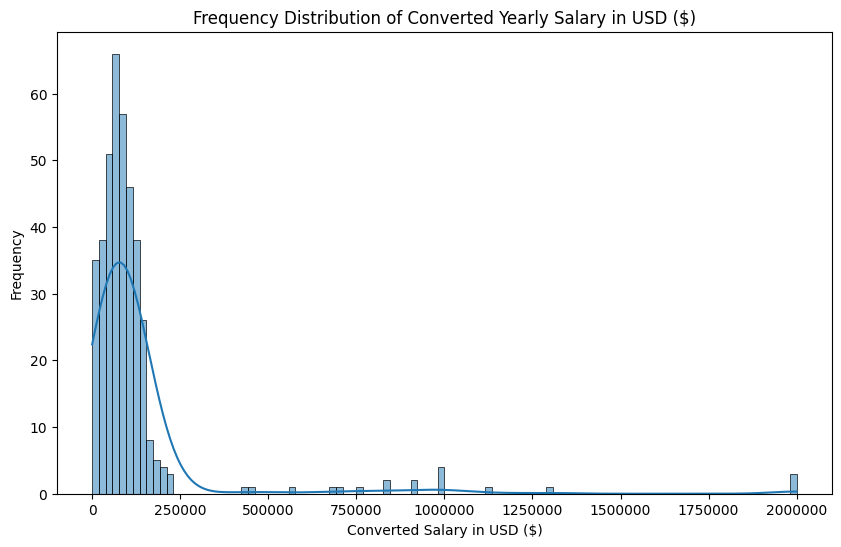

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = data_df.toPandas()

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['ConvertedSalary'], kde=True)
plt.title('Frequency Distribution of Converted Yearly Salary in USD ($)')
plt.xlabel('Converted Salary in USD ($)')
plt.ylabel('Frequency')

# Disable scientific notation on the x-axis
plt.ticklabel_format(style='plain', axis='x')

plt.show()

In [27]:
# Create the table
table = data_df.select("YearsCoding", "ConvertedSalary").orderBy(col("YearsCoding").asc())

# Display the table (optional)
table.show()


+-----------+---------------+
|YearsCoding|ConvertedSalary|
+-----------+---------------+
|  0-2 years|       434820.0|
|  0-2 years|        90000.0|
|  0-2 years|        74400.0|
|  0-2 years|        39164.0|
|  0-2 years|        68805.0|
|  0-2 years|        55000.0|
|  0-2 years|        82000.0|
|  0-2 years|         6000.0|
|  0-2 years|        36720.0|
|  0-2 years|        80000.0|
|  0-2 years|        25200.0|
|  0-2 years|        58340.0|
|  0-2 years|         8232.0|
|12-14 years|       108000.0|
|12-14 years|        64866.0|
|12-14 years|        36720.0|
|12-14 years|        55931.0|
|12-14 years|        55000.0|
|12-14 years|       140000.0|
|12-14 years|        52000.0|
+-----------+---------------+
only showing top 20 rows



In [28]:
from pyspark.sql.functions import avg, collect_list

# Group by "YearsCoding" and aggregate
result_df = table.groupBy("YearsCoding").agg(
    avg("ConvertedSalary").cast("int").alias("AverageSalary"),
    collect_list("ConvertedSalary").alias("Salaries")
)

# Show the result
result_df.show()

+----------------+-------------+--------------------+
|     YearsCoding|AverageSalary|            Salaries|
+----------------+-------------+--------------------+
|       0-2 years|        81437|[434820.0, 90000....|
|     12-14 years|       143589|[916764.0, 30000....|
|     15-17 years|       184522|[54336.0, 44449.0...|
|     18-20 years|       151862|[83224.0, 110148....|
|     21-23 years|       211817|[79175.0, 180000....|
|     24-26 years|       328811|[1000000.0, 12000...|
|     27-29 years|        80594|[52627.0, 125000....|
|       3-5 years|        80357|[9396.0, 7116.0, ...|
|30 or more years|       134169|[120000.0, 144000...|
|       6-8 years|       100874|[102000.0, 61680....|
|      9-11 years|        96790|[88116.0, 36720.0...|
+----------------+-------------+--------------------+



In [29]:
result_df = result_df.withColumn(
    "YearsCodingNumeric",
    when(col("YearsCoding") == "0-2 years", 0)
    .when(col("YearsCoding") == "3-5 years", 3)
    .when(col("YearsCoding") == "6-8 years", 6)
    .when(col("YearsCoding") == "9-11 years", 9)
    .when(col("YearsCoding") == "12-14 years", 12)
    .when(col("YearsCoding") == "15-17 years", 15)
    .when(col("YearsCoding") == "18-20 years", 18)
    .when(col("YearsCoding") == "21-23 years", 21)
    .when(col("YearsCoding") == "24-26 years", 24)
    .when(col("YearsCoding") == "27-29 years", 27)
    .when(col("YearsCoding") == "30 or more years", 30)
    .otherwise(None)
)

# Order the result_df by YearsCodingNumeric in ascending order
result_df = result_df.orderBy(col("YearsCodingNumeric").asc())

# Show the sorted result
result_df.show(n=data_df.count(), truncate=False)

+----------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|YearsCoding     |AverageSalary|Salaries                                                                                                                                                                                                                                  

In [30]:
filtered_df = data_df.filter((col("YearsCoding") == "27-29 years"))
filtered_df.show()

+----------+-----+----------+-------------+-------+------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+----------------+------+----------+---------------+--------------+--------------------+-------------------+--------------------+--------------------+----

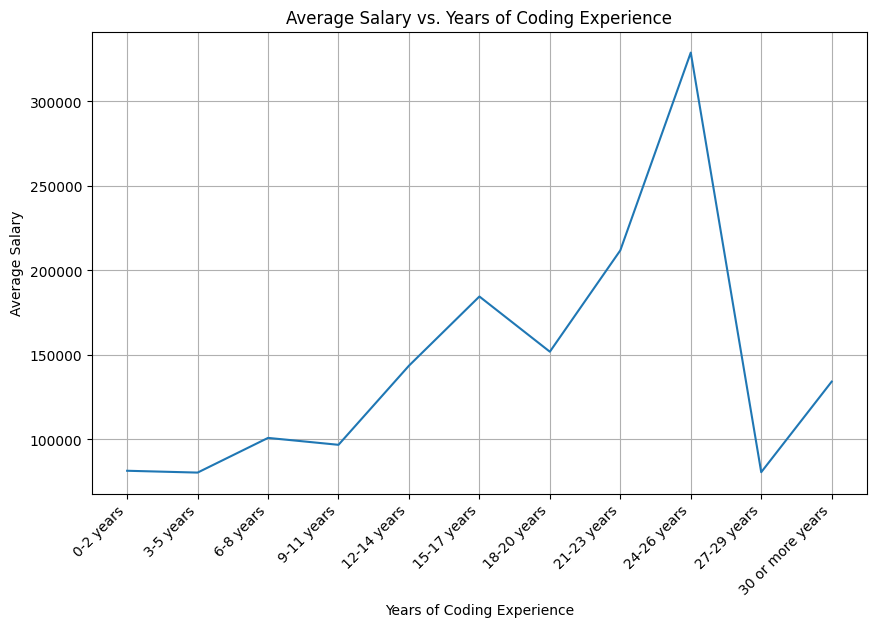

In [31]:
pandas_df = result_df.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(pandas_df['YearsCoding'], pandas_df['AverageSalary'])
plt.xlabel('Years of Coding Experience')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Salary')
plt.title('Average Salary vs. Years of Coding Experience')
plt.grid(True)
plt.show()

## 2. Relationship between Salary and Years Coding Prof

In [32]:
# Let's do the same analysis for 'YearsCodingProf'
table = data_df.select("YearsCodingProf", "ConvertedSalary").orderBy(col("YearsCoding").asc())
table.show()

+---------------+---------------+
|YearsCodingProf|ConvertedSalary|
+---------------+---------------+
|      0-2 years|       434820.0|
|      0-2 years|        90000.0|
|      0-2 years|        74400.0|
|      0-2 years|        39164.0|
|      3-5 years|        68805.0|
|      0-2 years|        55000.0|
|      0-2 years|        82000.0|
|      0-2 years|         6000.0|
|      0-2 years|        36720.0|
|      0-2 years|        80000.0|
|      0-2 years|        25200.0|
|      0-2 years|        58340.0|
|      0-2 years|         8232.0|
|    12-14 years|       108000.0|
|      6-8 years|        64866.0|
|      3-5 years|        36720.0|
|      3-5 years|        55931.0|
|    12-14 years|        55000.0|
|    12-14 years|       140000.0|
|      3-5 years|        52000.0|
+---------------+---------------+
only showing top 20 rows



In [33]:
# Group by "YearsCoding" and aggregate
result_df = table.groupBy("YearsCodingProf").agg(
    avg("ConvertedSalary").cast("int").alias("AverageSalary"),
    collect_list("ConvertedSalary").alias("Salaries")
)

# Show the result
result_df.show()

+----------------+-------------+--------------------+
| YearsCodingProf|AverageSalary|            Salaries|
+----------------+-------------+--------------------+
|     18-20 years|       243187|[160000.0, 125000...|
|     24-26 years|       139666|[128000.0, 205000...|
|       3-5 years|        98813|[68805.0, 52000.0...|
|     12-14 years|        99010|[130000.0, 58388....|
|      9-11 years|       105897|[62507.0, 43836.0...|
|     15-17 years|       272499|[54336.0, 58752.0...|
|       6-8 years|       144207|[916764.0, 30000....|
|30 or more years|       169886|[120000.0, 130000...|
|     21-23 years|       106507|[160000.0, 127000...|
|       0-2 years|       109733|[434820.0, 90000....|
+----------------+-------------+--------------------+



In [34]:
result_df = result_df.withColumn(
    "YearsCodingProfNumeric",
    when(col("YearsCodingProf") == "0-2 years", 0)
    .when(col("YearsCodingProf") == "3-5 years", 3)
    .when(col("YearsCodingProf") == "6-8 years", 6)
    .when(col("YearsCodingProf") == "9-11 years", 9)
    .when(col("YearsCodingProf") == "12-14 years", 12)
    .when(col("YearsCodingProf") == "15-17 years", 15)
    .when(col("YearsCodingProf") == "18-20 years", 18)
    .when(col("YearsCodingProf") == "21-23 years", 21)
    .when(col("YearsCodingProf") == "24-26 years", 24)
    .when(col("YearsCodingProf") == "27-29 years", 27)
    .when(col("YearsCodingProf") == "30 or more years", 30)
    .otherwise(None)
)

# Order the result_df by YearsCodingProfNumeric in ascending order
result_df = result_df.orderBy(col("YearsCodingProfNumeric").asc())

# Show the sorted result
result_df.show(n=data_df.count(), truncate=False)

+----------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [35]:
filtered_df = data_df.filter((col("YearsCodingProf") == "12-14 years"))
filtered_df.show()

+----------+-----+----------+--------------------+--------------+------------------+--------------------+--------------------+--------------------+--------------------+----------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+------+----------+---------------+--------------+--------------------+-------------------+--------------------+--

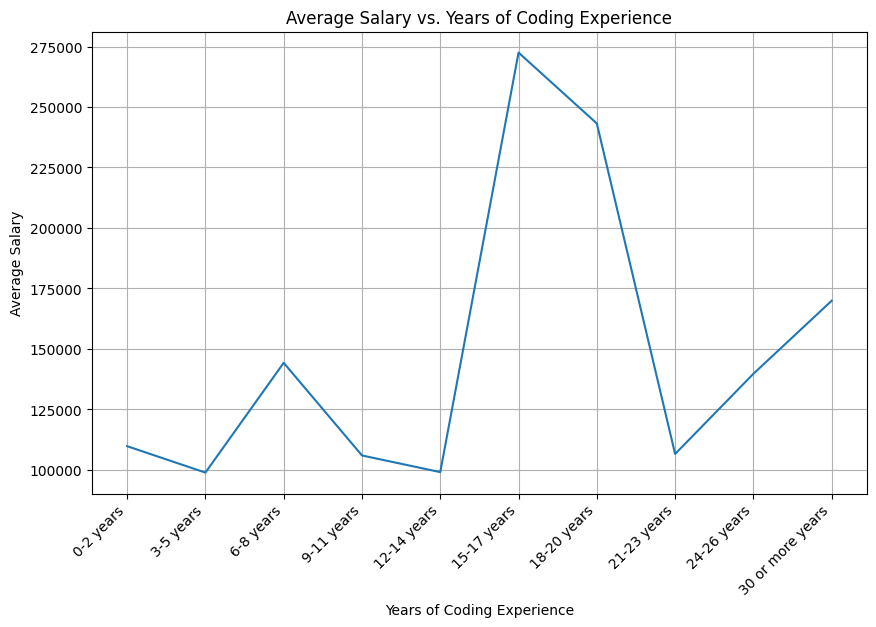

In [36]:
pandas_df = result_df.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(pandas_df['YearsCodingProf'], pandas_df['AverageSalary'])
plt.xlabel('Years of Coding Experience')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Salary')
plt.title('Average Salary vs. Years of Coding Experience')
plt.grid(True)
plt.show()

## 3. Which question have the biggest variance?



In [37]:
from pyspark.sql.functions import variance

# List of columns for which to calculate variance
columns_to_analyze = [
    "AssessJob1", "AssessJob2", "AssessJob3", "AssessJob4", "AssessJob5",
    "AssessJob6", "AssessJob7", "AssessJob8", "AssessJob9", "AssessJob10",
    "AssessBenefits1", "AssessBenefits2", "AssessBenefits3", "AssessBenefits4",
    "AssessBenefits5", "AssessBenefits6", "AssessBenefits7", "AssessBenefits8",
    "AssessBenefits9", "AssessBenefits10", "AssessBenefits11",
    "JobContactPriorities1", "JobContactPriorities2", "JobContactPriorities3",
    "JobContactPriorities4", "JobContactPriorities5",
    "JobEmailPriorities1", "JobEmailPriorities2", "JobEmailPriorities3",
    "JobEmailPriorities4", "JobEmailPriorities5", "JobEmailPriorities6",
    "JobEmailPriorities7",
    "AdsPriorities1", "AdsPriorities2", "AdsPriorities3",
    "AdsPriorities4", "AdsPriorities5", "AdsPriorities6", "AdsPriorities7"
]

# Calculate variance for specified columns
std_dev_df = data_df.select([variance(col(c)).alias(c) for c in columns_to_analyze])

std_dev_df.show()

+----------------+-----------------+-----------------+----------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+
|      AssessJob1|       AssessJob2|       AssessJob3|      AssessJob4|       AssessJob5|       AssessJob6|        AssessJob7|       AssessJob8|       AssessJob9|       AssessJob10|   AssessBenefits1|  AssessBenefits2|  AssessBenefits3|  A

In [38]:
# Calculate variance for specified columns
std_dev_df = data_df.select([variance(col(c)).alias(c) for c in columns_to_analyze])

# Find the column with the highest variance
max_variance_col = max(std_dev_df.collect()[0].asDict(), key=lambda k: std_dev_df.collect()[0][k])

print(f"The question with the highest variance is: {max_variance_col}")

The question with the highest variance is: AssessBenefits2
